## Importing libraries

In [11]:
import numpy as np
import pickle
from sklearn.neighbors import NearestNeighbors
import torch
from torchvision.models import resnet50
from torchvision import transforms
from PIL import Image


## importing Models

In [12]:
feature_list = pickle.load(open('embeddings.pkl', 'rb'))
feature_list = np.vstack([
    np.array(f).reshape(-1) for f in feature_list
])

print("Feature list shape:", feature_list.shape)



C:\Users\junai\AppData\Local\Temp\ipykernel_20420\1938549987.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  np.array(f).reshape(-1) for f in feature_list


Feature list shape: (44441, 2048)


In [13]:
filenames = pickle.load(open('filenames.pkl', 'rb'))
print("Filenames count:", len(filenames))


Filenames count: 44441


## Image pre processing and Feature Extraction

In [14]:
model = resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1]) 
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


d:\search_image\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\search_image\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
def get_image_embeddings(query_image_path):
    try:
        image = Image.open(query_image_path).convert("RGB")
        image_tensor = transform(image).unsqueeze(0)

        with torch.no_grad():
            features = model(image_tensor)

        embeddings = torch.flatten(features, start_dim=1) 
        return embeddings.numpy() 
    
    except Exception as e:
        print(f"Error processing {query_image_path}: {str(e)}")
        return None


## Training the NearestNeighbors and Quick test of the model

In [16]:
neighbors = NearestNeighbors(n_neighbors=5, algorithm='brute', metric='euclidean')
neighbors.fit(feature_list)


NearestNeighbors(algorithm='brute', metric='euclidean')

Top 5 similar images:


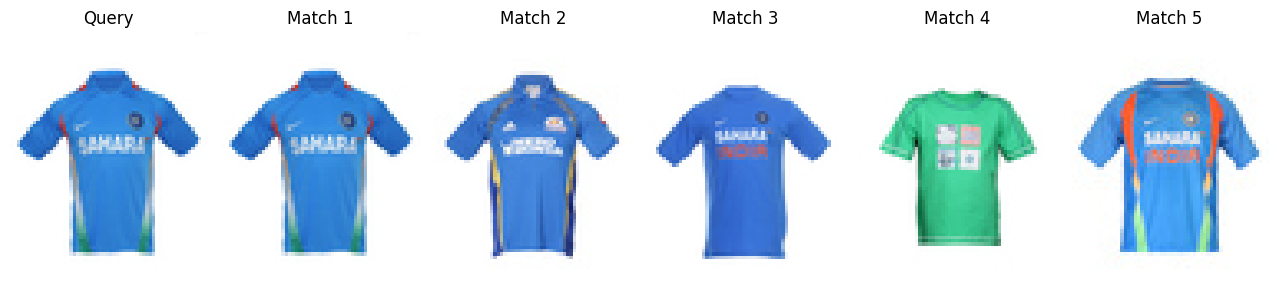

In [19]:
import matplotlib.pyplot as plt

query_path = '1164.jpg'

query_embedding = get_image_embeddings(query_path)

if query_embedding is not None:
    distances, indices = neighbors.kneighbors(query_embedding)

    print("Top 5 similar images:")

    # Plot the query image
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 7, 1)
    plt.imshow(Image.open(query_path))
    plt.title("Query")
    plt.axis('off')

    for i, idx in enumerate(indices[0]):
        img_path = filenames[idx]
        img = Image.open(img_path)

        plt.subplot(1, 7, i + 2)
        plt.imshow(img)
        plt.title(f"Match {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

else:
    print("Failed to process query image.")
